# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [75]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [76]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
#from google.colab import drive

#drive.mount("/content/gdrive")

In [77]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "C:/Users/your_username/Desktop/results/"

In [78]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

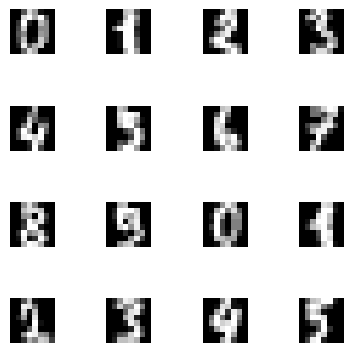

In [79]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [80]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [81]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        
        # Pass x through the neural network
        out = self.classnet(x)
        # Apply a softmax activation
        out = F.log_softmax(out, dim=1)
        # Get the class predictions
        _, y_pred = out.max(dim=1)
        # Convert the output to a long tensor
        y_pred = y_pred.long()

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        
        # Pass x through the neural network
        out = self.classnet(x)
        # Apply a log softmax activation
        out = F.log_softmax(out, dim=1)
        # Compute the negative log likelihood loss
        loss = self.nll(out, y.long())
        # Compute the average loss across samples
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
The objective function for a classification task is the negative log-likelihood (NLL) loss. It is a loss function and measures the difference between the predicted class probabilities and the true class labels. In mathematical terms, if we have C classes and the true class label for an input is y, then the negative log likelihood loss is defined as:

NLL = -log(p_y)

where p_y is the predicted probability of the true class label y.

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Yes, it is correct to use the log-softmax instead of the softmax for making predictions. It is because log-softmax is more numerically stable than softmax. The softmax function takes the exponent of the inputs, which can lead to numerical overflow when the input values are large. Taking the logarithm of the softmax output reduces the input values, which makes the computation more numerically stable. When making predictions, the argmax of the log-softmax output is equivalent to the argmax of the softmax output.

### 2.2 Evaluation

In [82]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [83]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [84]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [85]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [86]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [87]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN
num_channels = 1 # the number of channels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.6323810304914202, val ce=0.11142857142857143
Epoch: 10, val nll=0.13462127481188094, val ce=0.037142857142857144
Epoch: 20, val nll=0.10790727138519288, val ce=0.02857142857142857
Epoch: 30, val nll=0.10260258538382394, val ce=0.02857142857142857
Epoch: 40, val nll=0.09603893620627267, val ce=0.025714285714285714
Epoch: 50, val nll=0.0943448781967163, val ce=0.02857142857142857
Epoch: 60, val nll=0.0924024874823434, val ce=0.025714285714285714
Epoch: 70, val nll=0.09217615025384085, val ce=0.025714285714285714
Epoch: 80, val nll=0.09196035010474068, val ce=0.025714285714285714
Epoch: 90, val nll=0.09301523957933698, val ce=0.025714285714285714
-> FINAL PERFORMANCE: nll=0.37844963415090405, ce=0.07829977628635347


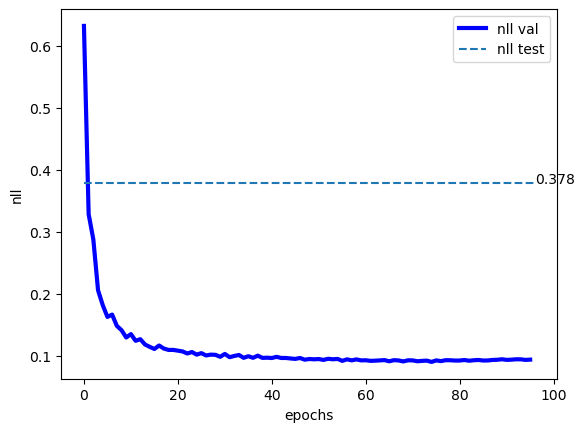

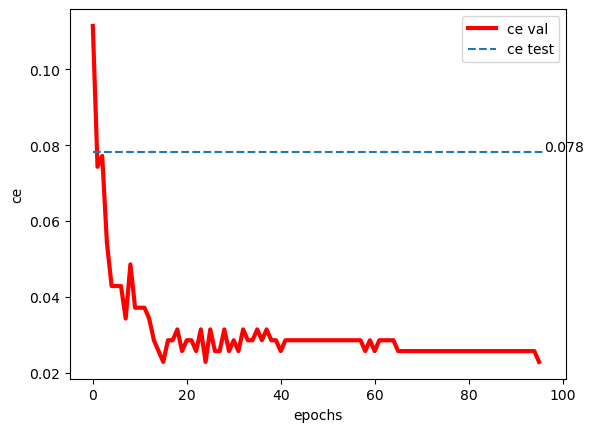


-> START classifier_cnn
Epoch: 0, val nll=1.637657972063337, val ce=0.3342857142857143
Epoch: 10, val nll=0.13673742498670305, val ce=0.03142857142857143
Epoch: 20, val nll=0.07569916776248387, val ce=0.025714285714285714
Epoch: 30, val nll=0.054426435700484686, val ce=0.017142857142857144
Epoch: 40, val nll=0.05181351065635681, val ce=0.022857142857142857
Epoch: 50, val nll=0.050383566660540446, val ce=0.02
Epoch: 60, val nll=0.04842434429696628, val ce=0.022857142857142857
Epoch: 70, val nll=0.04618544165045023, val ce=0.02
Epoch: 80, val nll=0.042583683047975815, val ce=0.014285714285714285
Epoch: 90, val nll=0.0408762229340417, val ce=0.011428571428571429
Epoch: 100, val nll=0.036538641154766086, val ce=0.011428571428571429
Epoch: 110, val nll=0.036553608163126874, val ce=0.011428571428571429
Epoch: 120, val nll=0.03601108843460679, val ce=0.011428571428571429
Epoch: 130, val nll=0.03445057427510619, val ce=0.011428571428571429
Epoch: 140, val nll=0.03329808884167246, val ce=0.011

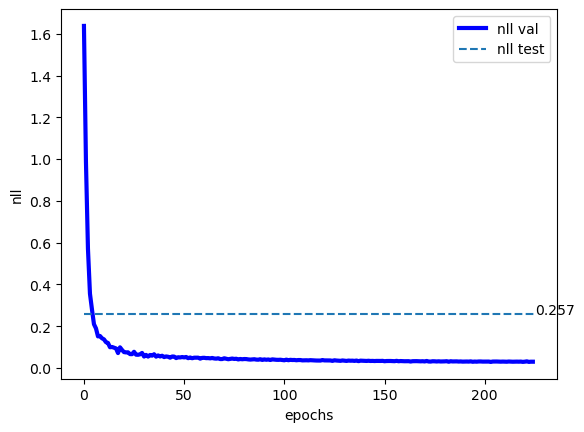

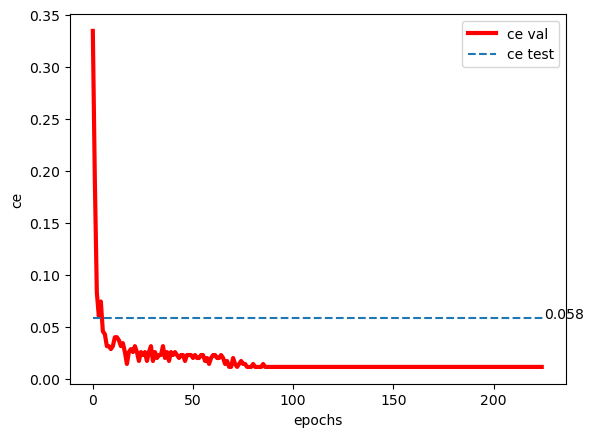

In [88]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Linear(D, M),  # input layer
            nn.ReLU(),  # activation function
            nn.Linear(M, M),  # hidden layer
            nn.ReLU(),  # activation function
            nn.Linear(M, K),  # output layer
            nn.LogSoftmax(dim=1)  # log-softmax activation for multi-class classification
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        # pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            # Reshape the input to a 4D tensor with shape [batch_size, num_channels, 8, 8]
            Reshape([num_channels, 8, 8]),
            # Convolutional layer with `num_kernels` kernels of size 3x3, using padding to keep the input size
            nn.Conv2d(in_channels=num_channels, out_channels=num_kernels, kernel_size=3, stride=1, padding=1),
            # ReLU activation function applied element-wise
            nn.ReLU(),
            # Max pooling layer with kernel size 2x2 and stride 2, reducing the input size by half
            nn.MaxPool2d(kernel_size=2),
            # Convolutional layer with `num_kernels` kernels of size 3x3, using padding to keep the input size
            nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels, kernel_size=3, stride=1, padding=1),
            # ReLU activation function applied element-wise
            nn.ReLU(),
            # Max pooling layer with kernel size 2x2 and stride 2, reducing the input size by half
            nn.MaxPool2d(kernel_size=2),
            # Flatten the 4D tensor to a 2D tensor with shape [batch_size, num_kernels*4]
            nn.Flatten(),
            # Fully connected layer with `num_kernels*4` input features and `M` output features
            nn.Linear(in_features=num_kernels*4, out_features=M),
            # ReLU activation function applied element-wise
            nn.ReLU(),
            # Fully connected layer with `M` input features and `K` output features
            nn.Linear(in_features=M, out_features=K),
            # Log-softmax activation function applied element-wise along the second dimension (class dimension)
            nn.LogSoftmax(dim=1)
        )

        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        # pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: In terms of the loss function, the MLP reached convergence faster compared to the CNN. Specifically, after 40 epochs, the MLP had an almost stable loss value of 0.0960, while the CNN had an almost stable loss value of 0.0365 after 100 epochs. 

In terms of classification error, the MLP reached convergence faster compared to the CNN. After 20 epochs, the MLP achieved an almost stable classification error of 0.0286, while the CNN achieved an almost stable classification error of 0.0114 after 90 epochs.

In conclusion, the MLP reached convergence faster than the CNN in terms of both the loss function and the classification error. However in both cases, the CNN had lower loss value and classification error when compared to the MLP.

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: Yes, CNNs are better suited to images that MLPs because the CNN has the ability to capture spatial information in images through the use of convolutional layers and pooling layers. These layers allow the CNN to learn local features such as edges and corners, which can be combined to form higher-level features such as shapes and objects. In contrast, an MLP treats each pixel as a separate feature and is not designed to handle the spatial structure of images.

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

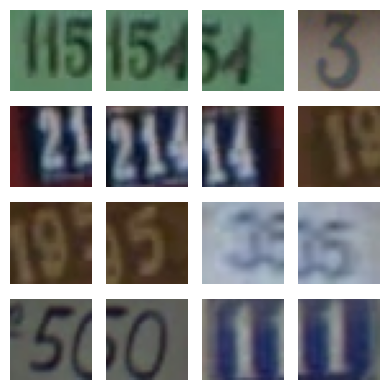

In [89]:
import os
import urllib.request
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

class SVHNDataset(Dataset):
    def __init__(self, path='./', mode='train', transforms=None, val_size=0.1):
        self.path = path
        self.mode = mode
        self.transforms = transforms
        
        # Download the training dataset if it does not exist
        if not os.path.exists(os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat')):
            url = 'http://ufldl.stanford.edu/housenumbers/'
            urllib.request.urlretrieve(url + 'train_32x32.mat', os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat'))
        
        # Download the test dataset if it does not exist
        if not os.path.exists(os.path.join('C:/Users/Sanskar/Desktop/svhn/test', 'test_32x32.mat')):
            url = 'http://ufldl.stanford.edu/housenumbers/'
            urllib.request.urlretrieve(url + 'test_32x32.mat', os.path.join('C:/Users/Sanskar/Desktop/svhn/test', 'test_32x32.mat'))
            
        # Load the dataset
        data = scipy.io.loadmat(os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat'))
        self.images = np.transpose(data['X'], (3, 2, 0, 1))
        self.labels = data['y']
        self.labels[self.labels == 10] = 0
        
        # Split the dataset into train and validation sets
        if mode == 'train' or mode == 'val':
            # Download the training dataset if it does not exist
            if not os.path.exists(os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat')):
                url = 'http://ufldl.stanford.edu/housenumbers/'
                urllib.request.urlretrieve(url + 'train_32x32.mat', os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat'))
            # Load the dataset
            data = scipy.io.loadmat(os.path.join('C:/Users/Sanskar/Desktop/svhn/train', 'train_32x32.mat'))
            self.images = np.transpose(data['X'], (3, 2, 0, 1))
            self.labels = data['y']
            self.labels[self.labels == 10] = 0
            if mode == 'train':
                val_size = int(len(self.images) * val_size)
                self.images = self.images[val_size:]
                self.labels = self.labels[val_size:]
            elif mode == 'val':
                val_size = int(len(self.images) * val_size)
                self.images = self.images[:val_size]
                self.labels = self.labels[:val_size]
        else:
            # Download the test dataset if it does not exist
            if not os.path.exists(os.path.join('C:/Users/Sanskar/Desktop/svhn/test', 'test_32x32.mat')):
                url = 'http://ufldl.stanford.edu/housenumbers/'
                urllib.request.urlretrieve(url + 'test_32x32.mat', os.path.join('C:/Users/Sanskar/Desktop/svhn/test', 'test_32x32.mat'))
            # Load the dataset
            data = scipy.io.loadmat(os.path.join('C:/Users/Sanskar/Desktop/svhn/test', 'test_32x32.mat'))
            self.images = np.transpose(data['X'], (3, 2, 0, 1))
            self.labels = data['y']
            self.labels[self.labels == 10] = 0
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index][0]
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, label

# Create a train dataset instance and plot some images

train_dataset = SVHNDataset(mode='train', val_size=0.1)
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.axis("off")
plt.tight_layout()
plt.show()


In [97]:
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] * x.shape[2] * x.shape[3] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [98]:
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        # y_pred = ...
        # Pass x through the neural network
        out = self.classnet(x)
        # Apply a softmax activation
        out = F.log_softmax(out, dim=1)
        # Get the class predictions
        _, y_pred = out.max(dim=1)
        # Convert the output to a long tensor
        y_pred = y_pred.long()

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        # loss = ...
        # ------
        # Pass x through the neural network
        out = self.classnet(x)
        # Apply a log softmax activation
        out = F.log_softmax(out, dim=1)
        # Compute the negative log likelihood loss
        loss = self.nll(out, y.long())
        # Compute the average loss across samples
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

In [99]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [100]:
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [101]:
# Initialize training, validation and test sets.
train_data = SVHNDataset(mode="train")
val_data = SVHNDataset(mode="val")
test_data = SVHNDataset(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [102]:
print("How do we get our data from SVHNDataset class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from SVHNDataset class? 

Feature example: [[[ 88  88  90 ...  89  88  88]
  [ 91  89  91 ...  90  89  86]
  [ 90  88  88 ...  90  90  86]
  ...
  [ 93  93  92 ...  87  89  89]
  [ 92  92  91 ...  89  92  92]
  [ 91  91  90 ...  92  91  91]]

 [[132 131 132 ... 132 132 133]
  [136 131 130 ... 132 131 130]
  [135 130 125 ... 130 130 128]
  ...
  [130 130 132 ... 126 129 129]
  [131 131 131 ... 130 132 131]
  [132 132 133 ... 134 134 134]]

 [[102 101 102 ... 104 105 104]
  [107 104 103 ... 107 106 104]
  [106 102 100 ... 108 108 104]
  ...
  [ 97  97  97 ...  98 102 102]
  [ 97  97  97 ... 100 104 104]
  [100  99  98 ... 104 105 106]]]
Feature example shape: (3, 32, 32)
Label example: 5


In [103]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(3,32,32))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 3, 32, 32])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 3072])


In [104]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 3072  # input dimension

# -> model hyperparams
M = 512  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN
num_channels = 3 # the number of channels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [105]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)


    # CNN
    if name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        
    
        classnet = nn.Sequential(
            # Reshape the input to the desired shape [num_channels, 32, 32]
            Reshape([num_channels, 32, 32]),
            # First convolutional layer with 16 output channels, 5x5 kernel, stride of 1, and padding of 2
            nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=5, stride=1, padding=2),
            # ReLU activation function
            nn.ReLU(),
            # Max pooling layer with 2x2 kernel
            nn.MaxPool2d(kernel_size=2),
            # Second convolutional layer with 512 output channels, 7x7 kernel, stride of 1, and padding of 3
            nn.Conv2d(in_channels=16, out_channels=512, kernel_size=7, stride=1, padding=3),
            # ReLU activation function
            nn.ReLU(),
            # Max pooling layer with 2x2 kernel
            nn.MaxPool2d(kernel_size=2),
            # Flatten the output to a 1D tensor
            nn.Flatten(),
            # First fully connected layer with M output neurons
            nn.Linear(in_features=512*4, out_features=M), 
            # ReLU activation function
            nn.ReLU(),
            # Second fully connected layer with 20 output neurons
            nn.Linear(in_features=M, out_features=20),
            # ReLU activation function
            nn.ReLU(),
            # Final fully connected layer with K output neurons and log softmax activation
            nn.Linear(in_features=20, out_features=K),
            nn.LogSoftmax(dim=1)
        )

        #pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )


-> START classifier_mlp


AssertionError: 